# HP Sensitivity Analysis

Figure A in the [paper](https://arxiv.org/abs/2007.09670).

In [1]:
import os
import sys

os.chdir('..')
sys.path.append('..')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# %matplotlib inline
%matplotlib notebook

In [3]:
import torch
import numpy as np
import pandas as pd
import datetime
from pprint import pprint
import matplotlib.pyplot as plt

In [4]:
from neural_pi.utils import Timer
from neural_pi.estimator.base import Randomness
from exp_qdp2 import yacht as experiment_config  # QD+ on Yacht dataset from `exp_qdp2.py`

## Configuration

Getting an existing experiment configuration.

In [5]:
config = experiment_config()['config']
pprint(config)

{'dataset': <neural_pi.data.ShuffledDataset object at 0x7f6047584b50>,
 'hyper_params': {'aggreg_func': [<function sem_aggreg at 0x7f6048ad8b00>,
                                  <function std_aggreg at 0x7f6048ad8b90>,
                                  <function snm_aggreg at 0x7f6048b385f0>],
                  'alpha': 0.05,
                  'batch_size': 100,
                  'decay_rate': 0.95,
                  'decay_steps': 50.0,
                  'device': 'cpu',
                  'ensemble_size': 5,
                  'epochs': 980,
                  'hidden_size': [50, 50],
                  'ksi': 10.0,
                  'lambda_1': 0.977,
                  'lambda_2': 0.55,
                  'learning_rate': 0.009,
                  'loss_func': <function qd_plus_loss at 0x7f6048ad8d40>,
                  'optimizer': <class 'torch.optim.adam.Adam'>,
                  'print_frequency': 10,
                  'scheduler': <class 'neural_pi.estimator.optimization.Exponentia

In [6]:
dataset = config['dataset']
split = config['split']
method = config['method']
hyper_params = config['hyper_params']

In [7]:
split['train_size'] = 0.81
split['test_size'] = 0.09
hyper_params['print_frequency'] = False
hyper_params['ensemble_size'] = 1
hyper_params['early_stopping'] = True
hyper_params['patience'] = 500
hyper_params['retry_limit'] = 1

## Hyper-Parameter Space

In [8]:
LAMBDA_NUM_SAMPLES = 101
lambda_1_array = np.linspace(0., 1., num=LAMBDA_NUM_SAMPLES)
lambda_2_array = np.linspace(0., 1., num=LAMBDA_NUM_SAMPLES)
ksi_array = np.linspace(10., 0., num=2)
print(f'lambda_1 = {lambda_1_array}')
print(f'lambda_2 = {lambda_2_array}')
print(f'ksi = {ksi_array}')

lambda_1 = [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
lambda_2 = [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.

## Training and Validation

Or loading existing results...

In [9]:
# File paths with HP sensitivity analysis results
PICP_FILE_PATH = 'notebooks/hpsa_picp.npy'
MPIW_FILE_PATH = 'notebooks/hpsa_mpiw.npy'
MSE_FILE_PATH = 'notebooks/hpsa_mse.npy'


def files_exist(file_paths):
    for fp in file_paths:
        if not os.path.isfile(fp):
            return False
    return True

In [10]:
if not files_exist([PICP_FILE_PATH, MPIW_FILE_PATH, MSE_FILE_PATH]):
    print('Running HP sensitivity analysis...\n')
    
    # Randomness
    SHUFFLE_ID = 5  # 0..19
    SEED = 1
    randomness = Randomness(SEED)
    r_seed = randomness.random_seed()
    
    # Temporary directory
    run_dir = 'temp/run_%s' % r_seed
    
    # Loading dataset
    (x_train, y_train), _, (x_val, y_val) = dataset.load(**split, shuffle=SHUFFLE_ID)

    # Initialize arrays for results
    hp_space_dimensions = (
        lambda_1_array.shape[0],
        lambda_2_array.shape[0],
        ksi_array.shape[0]
    )
    picp = np.zeros(hp_space_dimensions)
    mpiw = np.zeros(hp_space_dimensions)
    mse = np.zeros(hp_space_dimensions)
    
    # Training and validation over the HP space
    for l_1 in range(len(lambda_1_array)):
        for l_2 in range(len(lambda_2_array)):
            for k in range(len(ksi_array)):
                timer = Timer().start()
                
                hyper_params['lambda_1'] = lambda_1_array[l_1]
                hyper_params['lambda_2'] = lambda_2_array[l_2]
                hyper_params['ksi'] = ksi_array[k]  # ksi
                
                print('═ Training [l_1=%.2f, l_2=%.2f, ksi=%.1f, seed=%s]' % 
                      (hyper_params['lambda_1'], hyper_params['lambda_2'], hyper_params['ksi'], r_seed), 
                      end='')
                estimator = method(**hyper_params, seed=r_seed, output_dir=run_dir)
                estimator.fit(x_train, y_train, x_val, y_val)

                measures = estimator.evaluate_models(x_val, y_val, dataset.standardize_y)
                print('═ Evaluation:', measures)
                
                picp[l_1, l_2, k] = measures[0]['picp'] if len(measures) != 0 else np.nan
                mpiw[l_1, l_2, k] = measures[0]['mpiw'] if len(measures) != 0 else np.nan
                mse[l_1, l_2, k] = measures[0]['mse'] if len(measures) != 0 else np.nan
                
                timer.stop()
                print('═ Finished [duration=%.1f s]\n' % timer.duration())
    
    print('Saving results of HP sensitivity analysis... ', end='')
    np.save(PICP_FILE_PATH, picp)
    np.save(MPIW_FILE_PATH, mpiw)
    np.save(MSE_FILE_PATH, mse)
    print('DONE')
else:
    print('Loading results of HP sensitivity analysis... ', end='')
    picp = np.load(PICP_FILE_PATH)
    mpiw = np.load(MPIW_FILE_PATH)
    mse = np.load(MSE_FILE_PATH)
    print('DONE')

Loading results of HP sensitivity analysis... DONE


In [11]:
nmpiw = mpiw / (np.nanmax(mpiw) - np.nanmin(mpiw))  # Normalized MPIW

## Visualization

In [12]:
def imshow(ax, data, x, y, x_label, y_label, title, vmin, vmax, cmap):
    img = ax.imshow(data, vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    x_ticks, x_tick_labels = generate_ticks(x)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)
    
    y_ticks, y_tick_labels = generate_ticks(y)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_tick_labels)
    
    return img


def generate_ticks(x, tick_divs=10, round_=2):
    from collections import OrderedDict
    size = x.shape[0]
    ticks = list(OrderedDict.fromkeys(list(range(0, size, size // tick_divs)) + [size - 1]))
    labels = list(map(str, np.round(x[ticks], round_)))
    return ticks, labels


def plot_sensitivity_analysis(data_picp, data_nmpiw, data_mse, x, y, label_ext='', filename=None):
    fig = plt.figure(figsize=(2 * 6.4, 3 * 4.8))
    ax = fig.subplots(nrows=3, ncols=1)

    ax_picp = ax[0]
    ax_nmpiw = ax[1]
    ax_mse = ax[2]

    cmap_picp = matplotlib.cm.get_cmap('jet_r')
    cmap_picp.set_bad(color='gray')
    cmap_nmpiw = matplotlib.cm.get_cmap('jet')
    cmap_nmpiw.set_bad(color='gray')

    vmax_picp = 1.
    vmax_nmpiw = 0.01

    img_picp = imshow(ax_picp, data_picp, x, y, 
                      'Lambda 1', 'Lambda 2', 'PICP ' + label_ext, 
                      vmin=0., vmax=vmax_picp, cmap=cmap_picp)
    img_nmpiw = imshow(ax_nmpiw, data_nmpiw, x, y, 
                       'Lambda 1', 'Lambda 2', 'NMPIW ' + label_ext, 
                       vmin=0., vmax=vmax_nmpiw, cmap=cmap_nmpiw)
    img_mse = imshow(ax_mse, data_mse, x, y, 
                     'Lambda 1', 'Lambda 2', 'MSE ' + label_ext, 
                     vmin=0., vmax=vmax_nmpiw, cmap=cmap_nmpiw)


    cbar_tick_values_nmpiw = np.arange(0., vmax_nmpiw + 0.002, 0.002)
    cbar_tick_labels_nmpiw = list(map(str, np.round(cbar_tick_values_nmpiw, 3)))
    cbar_tick_labels_nmpiw[-1] = '> ' + cbar_tick_labels_nmpiw[-1]

    cbar_picp = plt.colorbar(img_picp, ax=ax_picp, pad=0.01)
    cbar_nmpiw = plt.colorbar(img_nmpiw, ax=ax_nmpiw, pad=0.01, ticks=cbar_tick_values_nmpiw)
    cbar_nmpiw.ax.set_yticklabels(cbar_tick_labels_nmpiw)
    cbar_mse = plt.colorbar(img_mse, ax=ax_mse, pad=0.01, ticks=cbar_tick_values_nmpiw)
    cbar_mse.ax.set_yticklabels(cbar_tick_labels_nmpiw)

    plt.tight_layout()
    plt.show()
    
    if filename:
        fig.savefig(f'{filename}.svg', format='svg', dpi=1000, bbox_inches='tight')
        fig.savefig(f'{filename}.pdf', format='pdf', dpi=1000, bbox_inches='tight')

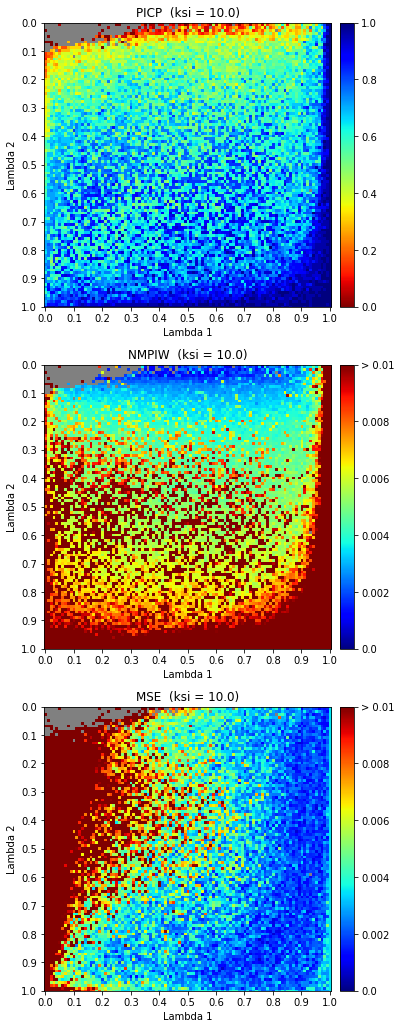

In [13]:
plot_sensitivity_analysis(picp[:, :, 0], nmpiw[:, :, 0], mse[:, :, 0], lambda_1_array, lambda_2_array, ' (ksi = 10.0)', 'sensitivity_analysis_ksi_10')

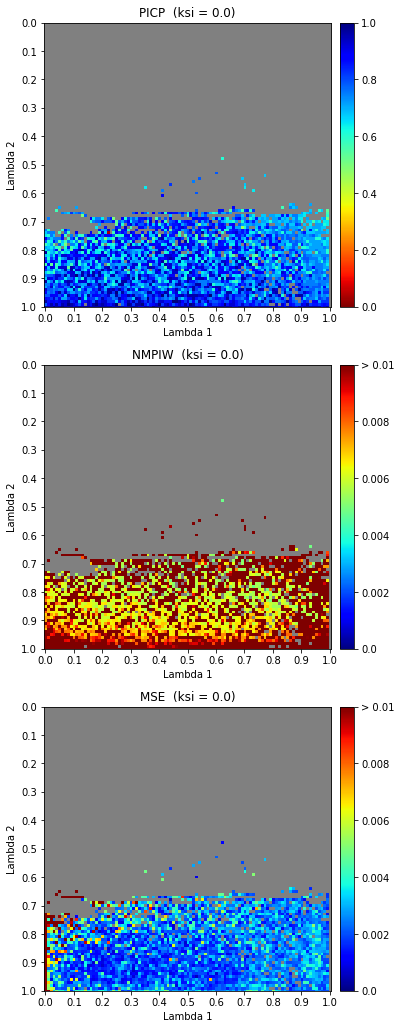

In [14]:
plot_sensitivity_analysis(picp[:, :, 1], nmpiw[:, :, 1], mse[:, :, 1], lambda_1_array, lambda_2_array, ' (ksi = 0.0)', 'sensitivity_analysis_ksi_0')